##### <center>Predicting Hazelnut Biomass using Image-derived Canopy Metrics and Random Forest</center>

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt
from fastai.tabular.core import Categorify, FillMissing, cont_cat_split, TabularPandas, Normalize
from fastai.tabular.all import tabular_learner
from fastbook import cluster_columns
import math
import pickle
from torch.nn import functional as F
from treeinterpreter import treeinterpreter as ti
import waterfall_chart

##### <center>Load and Pre-process the Data</center>

In [2]:
data = pd.read_csv("C:\\Users\\exx\\Downloads\\Rosemount_CanopyMetrics_Final.csv", low_memory=False)
data.columns

Index(['site', 'type', 'treeID', 'n_trees', 'diameter', 'area', 'volume',
       'width', 'length', 'diagonal_width', 'diagonal_length', 'biomass'],
      dtype='object')

In [3]:
# drop na from the data
data = data.dropna()

# subset only LiDAR type 
data = data[data['type'] == 'LiDAR']

# remmove descritpive columns
data = data.drop(columns=['site', 'type', 'treeID', 'n_trees'])

In [4]:
dependent_variable = 'biomass'
data[dependent_variable] = np.log(data[dependent_variable]) # taking log of dep var because error metric is RMSLE between actual and predicted biomass

In [5]:
# split into train and test sets
df, df_test = train_test_split(data, test_size=0.2)

In [6]:
# store indices in list
idx = list(df.index)

# set cond to subset first 85% of indices
cond = df.index.isin(idx[:int(len(idx)*0.85)])
train_idx = np.where(cond)[0]
valid_idx = np.where(~cond)[0]

splits = (list(train_idx), list(valid_idx))
procs = [Categorify, FillMissing]
cont, cat = cont_cat_split(df, 1, dep_var = dependent_variable)
to = TabularPandas(df, procs, cat, cont, y_names=dependent_variable, splits = splits)

In [7]:
len(to.train), len(to.valid)

(23, 5)

In [8]:
to.show(3) # shows embeddings for categorical values

,diameter,area,volume,width,length,diagonal_width,diagonal_length,biomass
26,3.190728,5.006864,5.539432,3.109818,2.41986,3.147406,2.566449,2.884801
21,2.468909,3.729064,5.634546,2.389860,2.34486,2.390613,2.349338,3.030134
30,3.383458,6.987432,9.075624,3.234810,3.26980,3.345883,3.275910,3.280911


In [9]:
to.items.head(3) # shows embedded values for categorical variables

,diameter,area,volume,width,length,diagonal_width,diagonal_length,biomass
26,3.190728,5.006864,5.539432,3.109818,2.41986,3.147406,2.566449,2.884801
21,2.468909,3.729064,5.634546,2.389860,2.34486,2.390613,2.349338,3.030134
30,3.383458,6.987432,9.075624,3.234810,3.26980,3.345883,3.275910,3.280911


##### <center>Create the Random Forest</center>

In [10]:
def randomForest(xs, y, n_estimators=40, max_samples=len(to.train),
                  max_features=0.5, min_samples_leaf=3, **kwargs):
    return RandomForestRegressor(n_jobs=-1, n_estimators=n_estimators,
                                max_samples=max_samples, max_features=max_features,
                                min_samples_leaf=min_samples_leaf, oob_score=True).fit(xs, y)

In [11]:
xs, y = to.train.xs, to.train.y
valid_xs, valid_y = to.valid.xs, to.valid.y
m = randomForest(xs, y)

In [12]:
# print feature names in random forest model
print(m.feature_names_in_)

['diameter' 'area' 'volume' 'width' 'length' 'diagonal_width' 'diagonal_length']


In [13]:
# functions for calculating rmse
def r_mse(pred, y): return round(math.sqrt(((pred-y)**2).mean()), 6)
def m_rmse(m, xs, y): return r_mse(m.predict(xs), y)

In [14]:
m_rmse(m, xs, y), m_rmse(m, valid_xs, valid_y)

(0.159865, 0.194466)

In [15]:
# set feature names for each tree in the random forest model
for est in m.estimators_:
    est.feature_names_in_ = m.feature_names_in_

In [16]:
preds = np.stack([t.predict(valid_xs) for t in m.estimators_])
preds.shape

(40, 5)

In [17]:
r_mse(preds.mean(0), valid_y)

0.194466

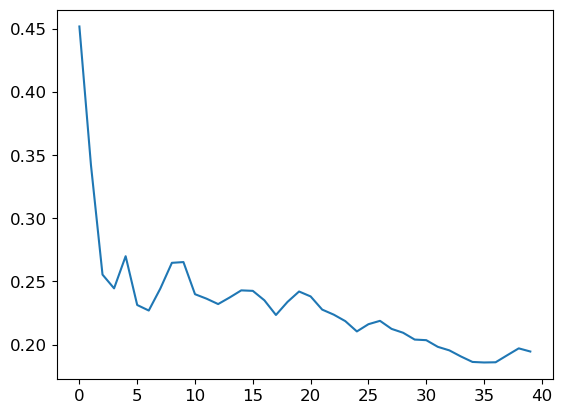

In [18]:
# plot mean prediction error of each estimator (decision tree) in the random forest
plt.plot([r_mse(preds[:i+1].mean(0), valid_y) for i in range(40)]);

In [19]:
# out-of-bag rmse error
r_mse(m.oob_prediction_, y)

0.271325

##### <center>Tree Variance for Prediction Confidence</center>

In [20]:
# std. dev. gives model confidence
preds_std = preds.std(0)
preds_std[:5]

array([0.19065567, 0.12077288, 0.37192679, 0.13952051, 0.14430723])

##### <center>Feature Importance</center>

In [21]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

In [22]:
feature_importance = rf_feat_importance(m, xs)
feature_importance[:10]

,cols,imp
2,volume,0.320007
4,length,0.247237
1,area,0.145533
6,diagonal_length,0.121405
0,diameter,0.096129
5,diagonal_width,0.034945
3,width,0.034745


In [23]:
def plot_feature_importance(feature_importance):
    return feature_importance.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

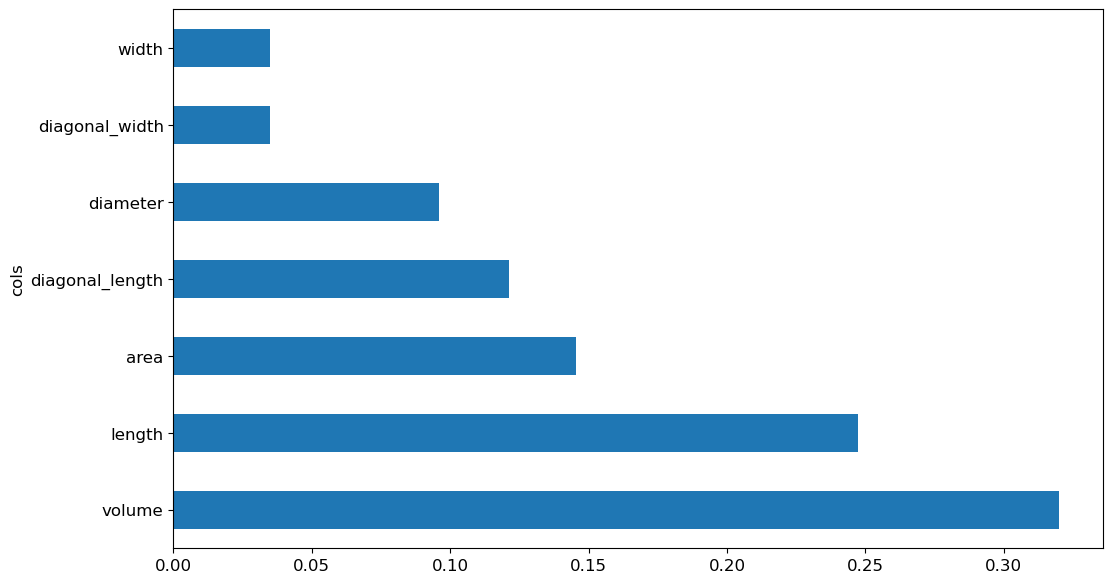

In [24]:
plot_feature_importance(feature_importance[:len(to.train)]);

##### <center>Removing Low-importance Variables</center>

In [25]:
to_keep = feature_importance[feature_importance.imp>0.005].cols
len(to_keep)

7

In [26]:
xs_imp = xs[to_keep]
valid_xs_imp = valid_xs[to_keep]
m_imp = randomForest(xs_imp, y)
m_rmse(m_imp, xs_imp, y), m_rmse(m_imp, valid_xs_imp, valid_y)

(0.153433, 0.168242)

In [27]:
len(xs.columns), len(xs_imp.columns)

(7, 7)

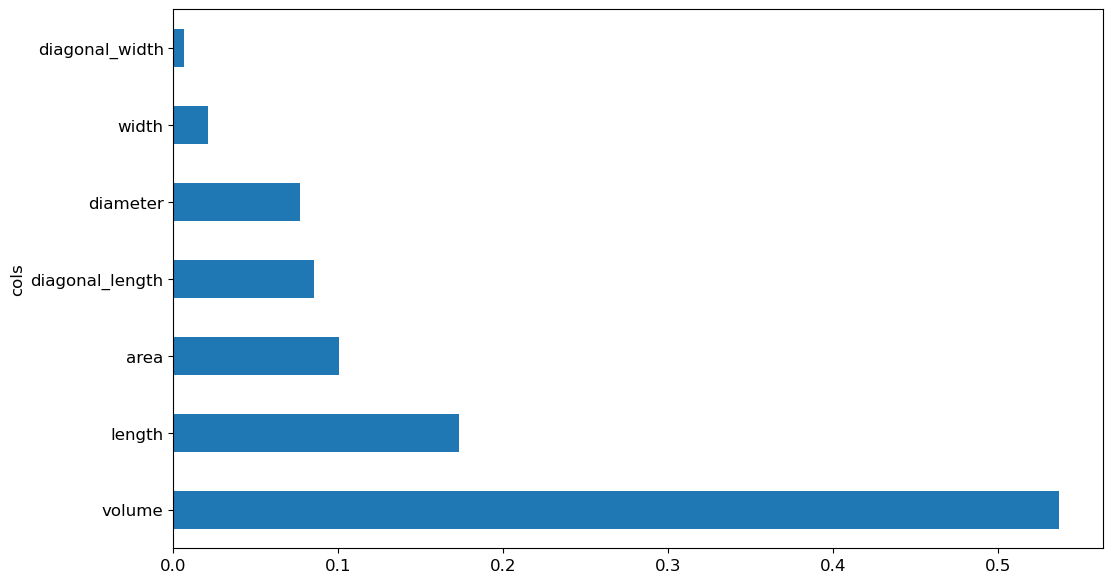

In [28]:
plot_feature_importance(rf_feat_importance(m_imp, xs_imp));

##### <center>Removing Redundant Features using Out-of-bag Error</center>

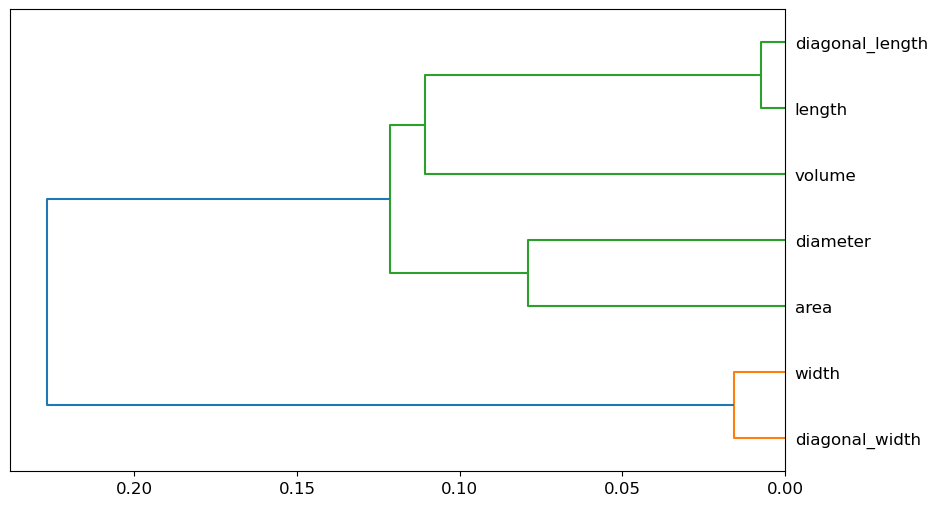

In [29]:
cluster_columns(xs_imp)

In [30]:
# OOB score used here is R^2
def get_oob(df):
    m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3,
                                  max_samples = len(to.train), max_features=0.5, n_jobs=-1, oob_score=True)
    m.fit(df, y)
    return m.oob_score_

In [31]:
get_oob(xs_imp)

0.7058603350313647

In [32]:
{c:get_oob(xs_imp.drop(c, axis=1)) for c in to_keep.tolist()}

{'volume': 0.5374137500613393,
 'length': 0.6562912883795109,
 'area': 0.6870378073886234,
 'diagonal_length': 0.7371885235674192,
 'diameter': 0.6513590409772297,
 'diagonal_width': 0.6784768889037212,
 'width': 0.6645836456044141}

In [33]:
# now try dropping multiple variables to see if oob improves
to_drop = ['diagonal_length','diagonal_width', 'diameter']
get_oob(xs_imp.drop(to_drop, axis=1))

0.7505661465504648

In [34]:
xs_final = xs_imp.drop(to_drop, axis=1)
valid_xs_final = valid_xs_imp.drop(to_drop, axis=1)


# save preprocessed data to pickle file
with open('Hazelnut_Biomass_Data_preProcessed_train.pkl', 'wb') as f:
    pickle.dump(xs_final, f)
with open('Hazelnut_Biomass_Data_preProcessed_valid.pkl', 'wb') as f:
    pickle.dump(valid_xs_final, f)

In [35]:
# check RMSE again to ensure accuracy hasn't substantially changed
m = randomForest(xs_final, y)
m_rmse(m, xs_final, y), m_rmse(m, valid_xs_final, valid_y)

(0.147908, 0.170508)

##### <center>Plot Partial Dependence of Most Important Variables</center>

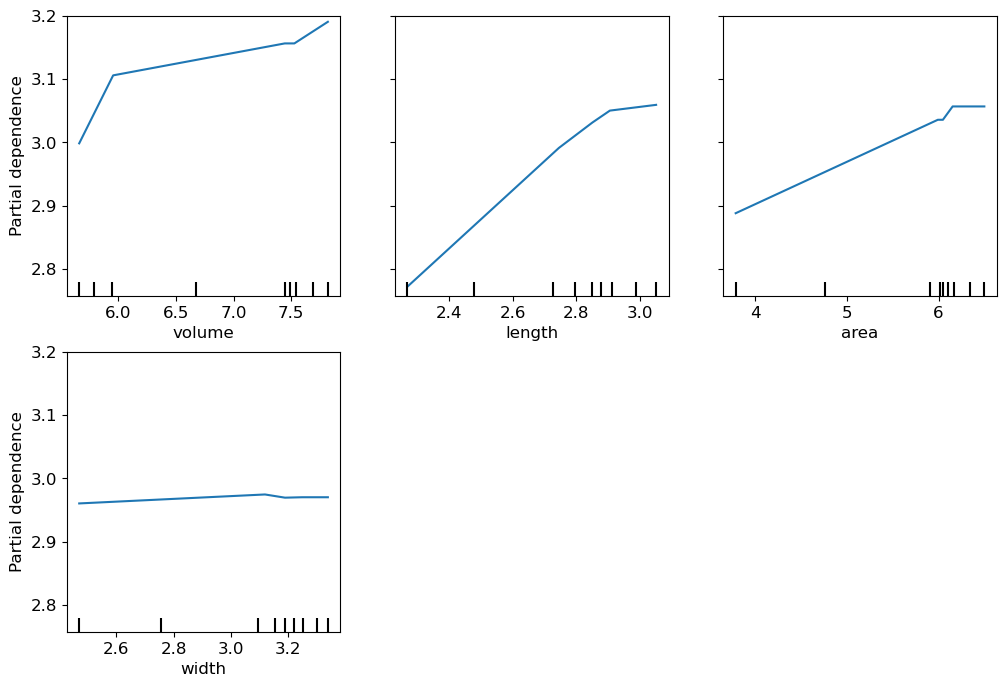

In [37]:
# look at feature importance plot above and store most important variables in a list
imp_vars = [f for f in m.feature_names_in_]

# partial dependence plot shows how each feature's individual values contribute to model prediction
fig,ax = plt.subplots(figsize=(12, 8))
PartialDependenceDisplay.from_estimator(m, valid_xs_final, imp_vars, grid_resolution=20, ax=ax);

##### <center>Use Tree Interpreters to Identify Factors that Influence Prediction</center>

In [38]:
row = valid_xs_final.iloc[:len(to.train)]
prediction, bias, contributions = ti.predict(m, row.values)

In [39]:
# look at just first row results
prediction[0], bias[0], contributions[0].sum()

(array([3.22582763]), 2.9551340844320224, 0.2706935440521706)

c:\Users\exx\.conda\envs\fastai_dl\Lib\site-packages\waterfall_chart.py:141: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y = y_height[loop] + row['amount']
c:\Users\exx\.conda\envs\fastai_dl\Lib\site-packages\waterfall_chart.py:139: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y = y_height[loop]


<module 'matplotlib.pyplot' from 'c:\\Users\\exx\\.conda\\envs\\fastai_dl\\Lib\\site-packages\\matplotlib\\pyplot.py'>

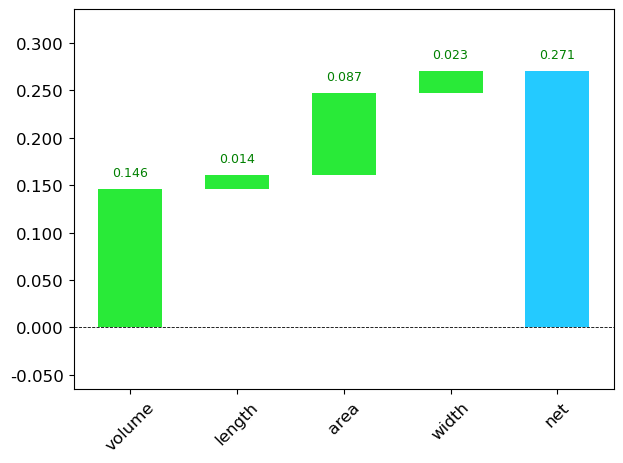

In [40]:
# plot contributions of independent variables using waterfall chart
## 'net' column is sum of negative (red) and positive (green) contributions of all indpendent variables
waterfall_chart.plot(valid_xs_final.columns, contributions[0], threshold=0.08, rotation_value=45, formatting='{:,.3f}')

##### <center>Compare Neural Network against Random Forest</center>

In [41]:
df_nn = df.copy()
df_nn_test = df_test.copy()

# keep only columns in imp_vars plus dependent variable
df_nn = df_nn[imp_vars + [dependent_variable]]
df_nn_test = df_nn_test[imp_vars + [dependent_variable]]

In [42]:
cont_nn, cat_nn = cont_cat_split(df_nn, max_card = 9000, dep_var = dependent_variable)
procs_nn = [Categorify, FillMissing, Normalize]
to_nn = TabularPandas(df_nn, procs_nn, cat_nn, cont_nn, y_names=dependent_variable, splits = splits)

In [43]:
# set up dataloaders for neural network
dls = to_nn.dataloaders(8, shuffle=False)

In [44]:
y = to_nn.train.y
y.min(), y.max()

(1.8870697021484375, 3.6737658977508545)

c:\Users\exx\.conda\envs\fastai_dl\Lib\site-packages\fastai\learner.py:51: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torc

SuggestedLRs(valley=0.0005754399462603033)

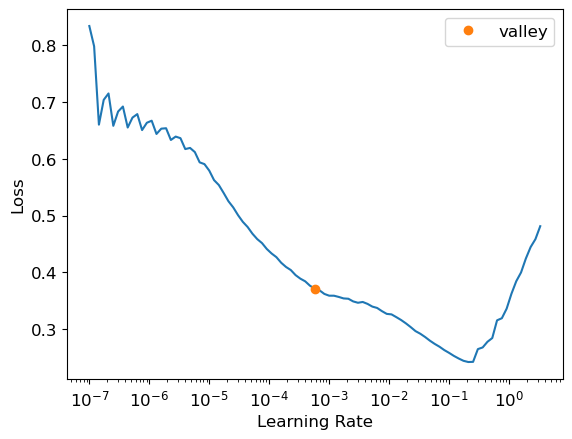

In [48]:
learn = tabular_learner(dls, y_range=(1, 4), layers=[1000,500,250,125], n_out=1, loss_func=F.mse_loss)
learn.lr_find()

In [46]:
dls.show_batch()

,volume,length,area,width,biomass
0,5.539432,2.41986,5.006864,3.109818,2.884801
1,5.634546,2.34486,3.729064,2.389860,3.030134
2,9.075624,3.26980,6.987432,3.234810,3.280911
3,6.150433,3.06982,6.110960,3.289807,3.173878
4,6.852620,2.71984,5.713356,3.104818,3.139833
5,6.320230,2.64485,4.088296,2.314864,3.131137
6,7.685225,3.16982,5.399168,3.104818,3.254243
7,3.963690,2.27987,4.198733,2.719841,2.312536


In [51]:
learn.fit_one_cycle(150, 1.2e-2)

epoch,train_loss,valid_loss,time
0,0.015818,0.081007,00:00
1,0.014771,0.074985,00:00
2,0.013692,0.068293,00:00
3,0.012563,0.061857,00:00
4,0.011464,0.049541,00:00
5,0.014762,0.035402,00:00
6,0.038966,0.034758,00:00
7,0.059242,0.027011,00:00
8,0.067136,0.176974,00:00
9,0.078144,0.075686,00:00


In [52]:
# check RMSE of neural network model
preds, targs = learn.get_preds()
r_mse(preds, targs)

0.061785

In [53]:
# save model
learn.save('nn_model')

Path('models/nn_model.pth')

In [54]:
# test nn_model on test data
to_nn_test = TabularPandas(df_nn_test, procs_nn, cat_nn, cont_nn, y_names=dependent_variable)

In [55]:
test_dl = to_nn_test.dataloaders(len(to_nn_test), shuffle=False)
test_dl.show_batch()

,volume,length,area,width,biomass
0,4.852227,2.66985,4.940272,2.739839,2.884801
1,10.908120,3.64478,8.183043,3.419800,3.543854
2,3.405238,2.19987,3.320061,2.184872,2.660259
3,4.461299,2.35986,4.329818,2.504854,2.484907
4,8.249636,3.20981,6.834125,3.294808,3.411148
5,3.199508,1.96989,3.167779,2.454856,2.484907
6,8.036151,2.77483,5.831292,3.429799,3.100092


In [56]:
# get preds on test data and compare RMSE with training value
preds_test, targs_test = learn.get_preds(dl=test_dl)
print(f'validation RMSE: {r_mse(preds, targs)} |', f'test RMSE: {r_mse(preds_test, targs_test)}')

validation RMSE: 0.061785 | test RMSE: 0.179712
